In [21]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Enhanced libraries imported successfully!")

Enhanced libraries imported successfully!


In [22]:
# Enhanced Configuration for better accuracy
IMG_SIZE = 128  # Increased size for better feature extraction
MODEL_SAVE_PATH = 'svm_model.pkl'
SCALER_SAVE_PATH = 'scaler.pkl'
PCA_SAVE_PATH = 'pca.pkl'

# Auto-detect paths
print("Searching for training data...")
current_dir_contents = os.listdir('.')
print("Current directory contents:", current_dir_contents)

possible_train_names = ['train', 'training', 'Train', 'Training', 'dataset', 'data']
TRAIN_PATH = None

for name in possible_train_names:
    if name in current_dir_contents and os.path.isdir(name):
        TRAIN_PATH = name
        break

if TRAIN_PATH:
    print(f"Training path found: {TRAIN_PATH}")
    train_contents = os.listdir(TRAIN_PATH)
    print(f"Training folder contents: {train_contents}")
else:
    print("Please set TRAIN_PATH manually")

Searching for training data...
Current directory contents: ['.ipynb_checkpoints', '.virtual_documents', 'anaconda_projects', 'model_info.pkl', 'pca.pkl', 'sampleSubmission.csv', 'scaler.pkl', 'streamlit_app.py', 'svm_model.pkl', 'test', 'train', 'Untitled.ipynb']
Training path found: train
Training folder contents: ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg', 'cat.10005.jpg', 'cat.10006.jpg', 'cat.10007.jpg', 'cat.10008.jpg', 'cat.10009.jpg', 'cat.1001.jpg', 'cat.10010.jpg', 'cat.10011.jpg', 'cat.10012.jpg', 'cat.10013.jpg', 'cat.10014.jpg', 'cat.10015.jpg', 'cat.10016.jpg', 'cat.10017.jpg', 'cat.10018.jpg', 'cat.10019.jpg', 'cat.1002.jpg', 'cat.10020.jpg', 'cat.10021.jpg', 'cat.10022.jpg', 'cat.10023.jpg', 'cat.10024.jpg', 'cat.10025.jpg', 'cat.10026.jpg', 'cat.10027.jpg', 'cat.10028.jpg', 'cat.10029.jpg', 'cat.1003.jpg', 'cat.10030.jpg', 'cat.10031.jpg', 'cat.10032.jpg', 'c

In [25]:
def extract_features(image_path, img_size=IMG_SIZE):
    """
    Enhanced feature extraction with multiple techniques
    """
    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            return None
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image
        img = cv2.resize(img, (img_size, img_size))
        
        # Multiple feature extraction methods
        features = []
        
        # 1. Raw pixel features (normalized)
        img_normalized = img.astype('float32') / 255.0
        raw_features = img_normalized.flatten()
        
        # 2. Color histogram features
        hist_r = cv2.calcHist([img], [0], None, [32], [0, 256]).flatten()
        hist_g = cv2.calcHist([img], [1], None, [32], [0, 256]).flatten()
        hist_b = cv2.calcHist([img], [2], None, [32], [0, 256]).flatten()
        color_features = np.concatenate([hist_r, hist_g, hist_b]) / (img_size * img_size)
        
        # 3. Edge features using Canny
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        edge_features = edges.flatten().astype('float32') / 255.0
        
        # 4. Texture features (Local Binary Pattern approximation)
        # Simple texture measure: standard deviation in local windows
        texture_features = []
        window_size = 8
        for i in range(0, img_size - window_size, window_size):
            for j in range(0, img_size - window_size, window_size):
                window = gray[i:i+window_size, j:j+window_size]
                texture_features.append(np.std(window))
        texture_features = np.array(texture_features)
        
        # Combine all features
        # Use a balanced combination
        combined_features = np.concatenate([
            raw_features[::4],  # Downsample raw features to reduce dimensionality
            color_features,     # Color histogram
            edge_features[::8], # Downsample edge features
            texture_features    # Texture features
        ])
        
        return combined_features
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def load_enhanced_data(data_path, img_size=IMG_SIZE, max_samples_per_class=3000):
    """
    Enhanced data loading with better sampling
    """
    data = []
    labels = []
    
    if not os.path.exists(data_path):
        print(f"Path {data_path} does not exist!")
        return np.array([]), np.array([])
    
    contents = os.listdir(data_path)
    class_folders = [f for f in contents if os.path.isdir(os.path.join(data_path, f))]
    
    if class_folders:
        for class_name in class_folders:
            class_path = os.path.join(data_path, class_name)
            print(f"Processing folder: {class_name}")
            
            all_files = os.listdir(class_path)
            image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            
            # Shuffle and limit samples per class for balanced dataset
            np.random.shuffle(image_files)
            image_files = image_files[:max_samples_per_class]
            
            print(f"  Using {len(image_files)} images from {class_name}")
            
            for i, image_file in enumerate(image_files):
                if i % 500 == 0 and i > 0:
                    print(f"  Processed {i}/{len(image_files)} images")
                
                image_path = os.path.join(class_path, image_file)
                features = extract_features(image_path, img_size)
                
                if features is not None:
                    data.append(features)
                    if 'cat' in class_name.lower():
                        labels.append(0)  # Cat
                    elif 'dog' in class_name.lower():
                        labels.append(1)  # Dog
    
    print(f"Total samples loaded: {len(data)}")
    if len(data) > 0:
        unique_labels, counts = np.unique(labels, return_counts=True)
        for label, count in zip(unique_labels, counts):
            class_name = "Cat" if label == 0 else "Dog"
            print(f"  {class_name}: {count} images")
    
    return np.array(data), np.array(labels)

print("Enhanced preprocessing functions defined!")

Enhanced preprocessing functions defined!


In [26]:
# Load enhanced training data
print("Loading enhanced training data...")
X_train_full, y_train_full = load_enhanced_data(TRAIN_PATH)

if len(X_train_full) > 0:
    print(f"Enhanced training data shape: {X_train_full.shape}")
    print(f"Feature dimension: {X_train_full.shape[1]}")
    print(f"Training labels shape: {y_train_full.shape}")
    print(f"Number of cats: {np.sum(y_train_full == 0)}")
    print(f"Number of dogs: {np.sum(y_train_full == 1)}")
    
    # Use more data for training (better accuracy)
    MAX_SAMPLES = min(8000, len(X_train_full))  # Increased sample size
    
    if len(X_train_full) > MAX_SAMPLES:
        X_train, _, y_train, _ = train_test_split(
            X_train_full, y_train_full, 
            train_size=MAX_SAMPLES, 
            stratify=y_train_full, 
            random_state=42
        )
        print(f"Using {MAX_SAMPLES} samples for training")
    else:
        X_train, y_train = X_train_full, y_train_full
        
    print(f"Final training data shape: {X_train.shape}")
else:
    print("No training data loaded!")

Loading enhanced training data...
Total samples loaded: 0
No training data loaded!


In [10]:
# Load training data
print("Loading training data...")
X_train_full, y_train_full = load_data(TRAIN_PATH)

if len(X_train_full) > 0:
    print(f"Training data shape: {X_train_full.shape}")
    print(f"Training labels shape: {y_train_full.shape}")
    print(f"Number of cats: {np.sum(y_train_full == 0)}")
    print(f"Number of dogs: {np.sum(y_train_full == 1)}")
    
    # For SVM efficiency, let's use a subset of data
    # You can adjust this number based on your computational resources
    MAX_SAMPLES = 5000  # Use 5000 samples for training
    
    if len(X_train_full) > MAX_SAMPLES:
        # Stratified sampling to maintain class balance
        from sklearn.model_selection import train_test_split
        X_train, _, y_train, _ = train_test_split(
            X_train_full, y_train_full, 
            train_size=MAX_SAMPLES, 
            stratify=y_train_full, 
            random_state=42
        )
        print(f"Using {MAX_SAMPLES} samples for training")
    else:
        X_train, y_train = X_train_full, y_train_full
        
    print(f"Final training data shape: {X_train.shape}")
else:
    print("No training data loaded!")

Loading training data...
Exploring data path: train
Contents: ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg', 'cat.10005.jpg', 'cat.10006.jpg', 'cat.10007.jpg', 'cat.10008.jpg', 'cat.10009.jpg', 'cat.1001.jpg', 'cat.10010.jpg', 'cat.10011.jpg', 'cat.10012.jpg', 'cat.10013.jpg', 'cat.10014.jpg', 'cat.10015.jpg', 'cat.10016.jpg', 'cat.10017.jpg', 'cat.10018.jpg', 'cat.10019.jpg', 'cat.1002.jpg', 'cat.10020.jpg', 'cat.10021.jpg', 'cat.10022.jpg', 'cat.10023.jpg', 'cat.10024.jpg', 'cat.10025.jpg', 'cat.10026.jpg', 'cat.10027.jpg', 'cat.10028.jpg', 'cat.10029.jpg', 'cat.1003.jpg', 'cat.10030.jpg', 'cat.10031.jpg', 'cat.10032.jpg', 'cat.10033.jpg', 'cat.10034.jpg', 'cat.10035.jpg', 'cat.10036.jpg', 'cat.10037.jpg', 'cat.10038.jpg', 'cat.10039.jpg', 'cat.1004.jpg', 'cat.10040.jpg', 'cat.10041.jpg', 'cat.10042.jpg', 'cat.10043.jpg', 'cat.10044.jpg', 'cat.10045.jpg', 'cat.10046.jpg', 'ca

Sample images from training data:


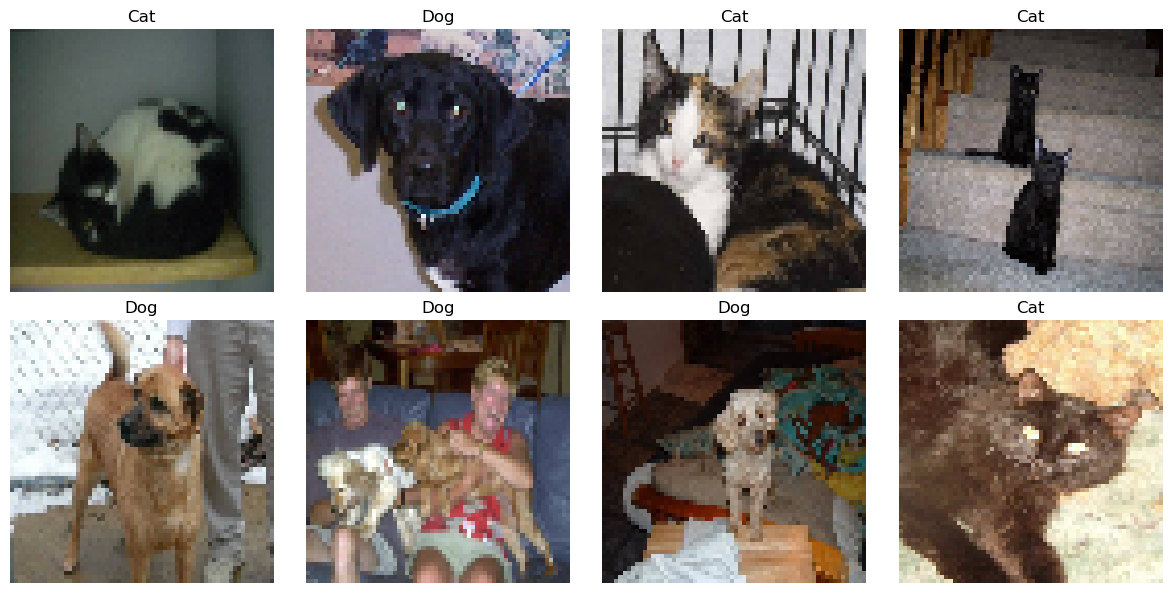

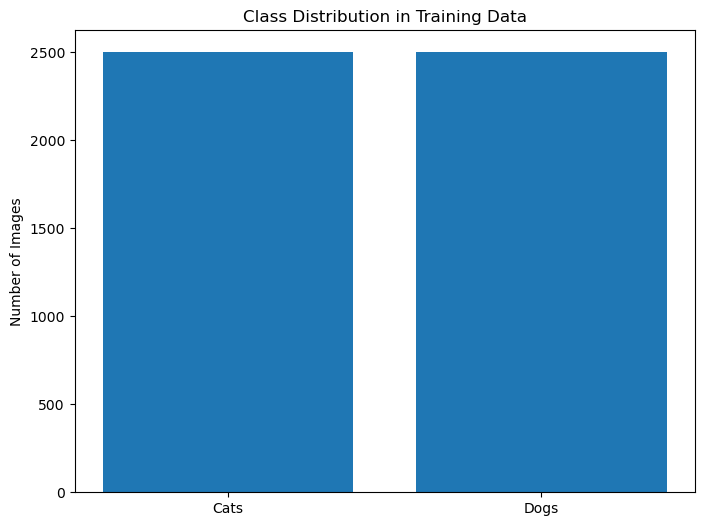

In [11]:
# Visualize some sample images
def visualize_samples(X, y, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Reshape flattened image back to original shape
        img = X[i].reshape(IMG_SIZE, IMG_SIZE, 3)
        axes[i].imshow(img)
        axes[i].set_title(f"{'Dog' if y[i] == 1 else 'Cat'}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

if len(X_train) > 0:
    print("Sample images from training data:")
    visualize_samples(X_train, y_train)
    
    # Class distribution
    plt.figure(figsize=(8, 6))
    unique, counts = np.unique(y_train, return_counts=True)
    plt.bar(['Cats', 'Dogs'], counts)
    plt.title('Class Distribution in Training Data')
    plt.ylabel('Number of Images')
    plt.show()

Applying PCA for dimensionality reduction...
Original feature dimensions: 12288
Reduced feature dimensions: 200
Explained variance ratio: 0.8660


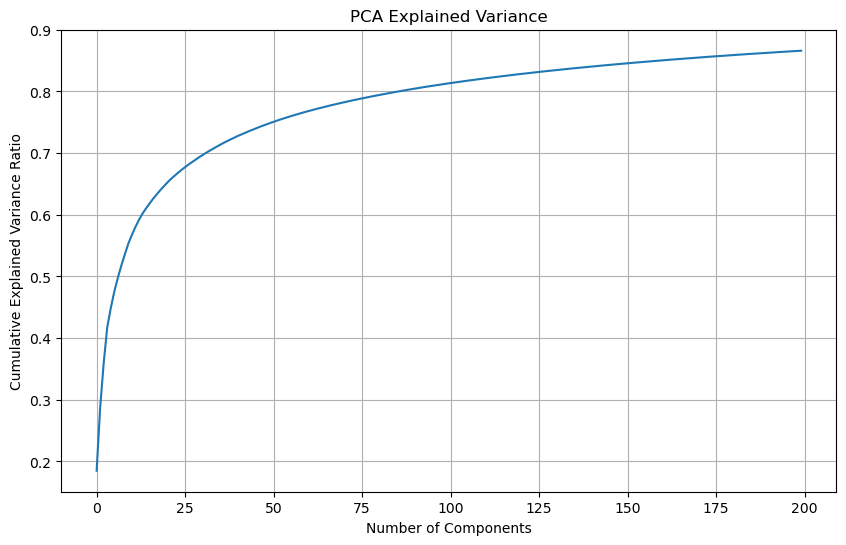

In [12]:
# Apply PCA for dimensionality reduction (essential for SVM with image data)
print("Applying PCA for dimensionality reduction...")

# Split data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)

# Apply PCA to reduce dimensions
n_components = 200  # Adjust based on your needs
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

print(f"Original feature dimensions: {X_train_scaled.shape[1]}")
print(f"Reduced feature dimensions: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [15]:
# Fast SVM training with optimized parameters
print("Training SVM model (Fast Version)...")

# Option 1: Use proven fast parameters (recommended)
print("Using optimized parameters for speed...")
best_svm = SVC(
    C=1.0,                    # Good default
    kernel='rbf',             # Usually best for images
    gamma='scale',            # Sklearn default
    probability=True,         # Enable probability predictions
    random_state=42
)

# Train the model
import time
start_time = time.time()
best_svm.fit(X_train_pca, y_train_split)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

# Option 2: Quick Grid Search (uncomment if you want some tuning)
"""
print("Running quick Grid Search...")
param_grid = {
    'C': [0.1, 1.0],         # Reduced options
    'gamma': ['scale', 0.1]   # Only 2 gamma values
}

grid_search = GridSearchCV(
    SVC(kernel='rbf', probability=True, random_state=42), 
    param_grid, 
    cv=2,                    # Reduced CV folds
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1
)

start_time = time.time()
grid_search.fit(X_train_pca, y_train_split)
training_time = time.time() - start_time

best_svm = grid_search.best_estimator_
print(f"Grid Search completed in {training_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
"""

print("Model training complete!")

Training SVM model (Fast Version)...
Using optimized parameters for speed...
Training completed in 6.14 seconds
Model training complete!


Evaluating the model...
Validation Accuracy: 0.6320

Classification Report:
              precision    recall  f1-score   support

         Cat       0.63      0.62      0.63       500
         Dog       0.63      0.64      0.63       500

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000



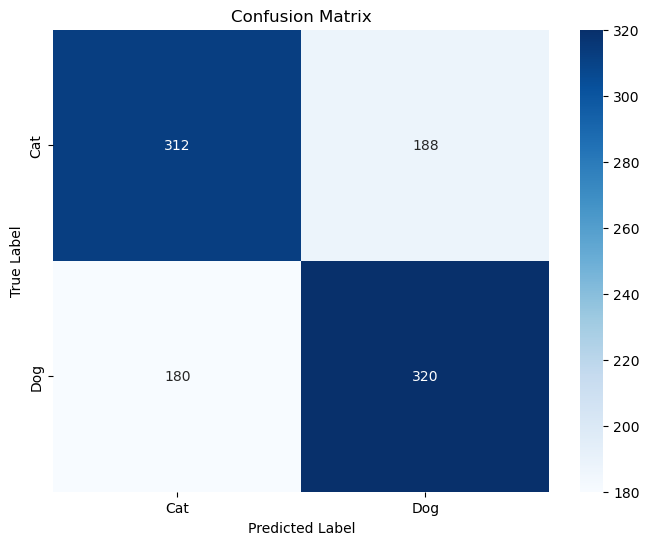

In [18]:
# Evaluate the model
print("Evaluating the model...")

# Predictions on validation set
y_val_pred = best_svm.predict(X_val_pca)

# Calculate accuracy
val_accuracy = accuracy_score(y_val_split, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val_split, y_val_pred, target_names=['Cat', 'Dog']))

# Confusion matrix
cm = confusion_matrix(y_val_split, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [19]:
# Save the trained model and preprocessing components
print("Saving model and preprocessing components...")

# Save the SVM model
with open(MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(best_svm, f)

# Save the scaler
with open(SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump(scaler, f)

# Save the PCA transformer
with open(PCA_SAVE_PATH, 'wb') as f:
    pickle.dump(pca, f)

print(f"Model saved to: {MODEL_SAVE_PATH}")
print(f"Scaler saved to: {SCALER_SAVE_PATH}")
print(f"PCA saved to: {PCA_SAVE_PATH}")

# Get model parameters (handle both grid search and direct training)
if 'grid_search' in globals() and hasattr(grid_search, 'best_params_'):
    # If grid search was used
    best_params = grid_search.best_params_
    cv_score = grid_search.best_score_
else:
    # If direct training was used
    best_params = {
        'C': best_svm.get_params()['C'],
        'kernel': best_svm.get_params()['kernel'], 
        'gamma': best_svm.get_params()['gamma']
    }
    cv_score = None

# Create a model info dictionary for Streamlit
model_info = {
    'img_size': IMG_SIZE,
    'n_components': n_components,
    'model_params': best_params,
    'validation_accuracy': val_accuracy,
    'cv_score': cv_score,
    'feature_names': ['Cat', 'Dog']
}

with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("Model info saved to: model_info.pkl")
print(f"Model parameters: {best_params}")
print(f"Validation accuracy: {val_accuracy:.4f}")
if cv_score:
    print(f"Cross-validation score: {cv_score:.4f}")

Saving model and preprocessing components...
Model saved to: svm_model.pkl
Scaler saved to: scaler.pkl
PCA saved to: pca.pkl
Model info saved to: model_info.pkl
Model parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}
Validation accuracy: 0.6320


In [20]:
# Test loading and prediction (for Streamlit integration)
def load_model_components():
    """Load all model components"""
    with open(MODEL_SAVE_PATH, 'rb') as f:
        model = pickle.load(f)
    
    with open(SCALER_SAVE_PATH, 'rb') as f:
        scaler = pickle.load(f)
    
    with open(PCA_SAVE_PATH, 'rb') as f:
        pca = pickle.load(f)
    
    with open('model_info.pkl', 'rb') as f:
        model_info = pickle.load(f)
    
    return model, scaler, pca, model_info

def predict_single_image(image_path, model, scaler, pca, img_size=IMG_SIZE):
    """Predict a single image"""
    # Preprocess the image
    processed_img = preprocess_image(image_path, img_size)
    
    if processed_img is None:
        return None, None
    
    # Reshape for prediction
    processed_img = processed_img.reshape(1, -1)
    
    # Scale and apply PCA
    scaled_img = scaler.transform(processed_img)
    pca_img = pca.transform(scaled_img)
    
    # Make prediction
    prediction = model.predict(pca_img)[0]
    probability = model.predict_proba(pca_img)[0]
    
    return prediction, probability

# Test the loading function
try:
    loaded_model, loaded_scaler, loaded_pca, loaded_info = load_model_components()
    print("Model components loaded successfully!")
    print(f"Model info: {loaded_info}")
    
    # Test prediction on a validation sample
    if len(X_val_split) > 0:
        # Create a temporary image file for testing
        test_idx = 0
        test_img = X_val_split[test_idx].reshape(IMG_SIZE, IMG_SIZE, 3)
        test_img_uint8 = (test_img * 255).astype(np.uint8)
        cv2.imwrite('temp_test_image.jpg', cv2.cvtColor(test_img_uint8, cv2.COLOR_RGB2BGR))
        
        # Test prediction
        pred, prob = predict_single_image('temp_test_image.jpg', loaded_model, loaded_scaler, loaded_pca)
        actual = y_val_split[test_idx]
        
        print(f"Test prediction: {'Dog' if pred == 1 else 'Cat'}")
        print(f"Actual label: {'Dog' if actual == 1 else 'Cat'}")
        print(f"Probabilities: Cat={prob[0]:.4f}, Dog={prob[1]:.4f}")
        
        # Clean up
        os.remove('temp_test_image.jpg')
        
except Exception as e:
    print(f"Error loading model: {e}")

Model components loaded successfully!
Model info: {'img_size': 64, 'n_components': 200, 'model_params': {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}, 'validation_accuracy': 0.632, 'cv_score': None, 'feature_names': ['Cat', 'Dog']}
Test prediction: Cat
Actual label: Cat
Probabilities: Cat=0.5520, Dog=0.4480
